In [1]:
import cv2
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from common import clock, mosaic

In [2]:
SZ = 20
CLASS_N = 10


def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return digits, labels


def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SZ * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img


def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('Accuracy: %.2f %%' % ((1 - err) * 100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[..., :2] = 0

        vis.append(img)
    return mosaic(25, vis)


def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ * SZ) / 255.0


def get_hog():
    winSize = (20, 20)
    blockSize = (10, 10)
    blockStride = (5, 5)
    cellSize = (10, 10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                            histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradient)

    return hog

In [3]:
print('Loading digits from digits.png ... ')
# Load data.
digits, labels = load_digits('digits.png')

print('Shuffle data ... ')
# Shuffle data
rand = np.random.RandomState(10)
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

print('Deskew images ... ')
digits_deskewed = list(map(deskew, digits))

print('Defining HoG parameters ...')
# HoG feature descriptor
hog = get_hog()

print('Calculating HoG descriptor for every image ... ')
hog_descriptors = []
for img in digits_deskewed:
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)

print('Spliting data into training (90%) and test set (10%)... ')
train_n = int(0.9 * len(hog_descriptors))
digits_train, digits_test = np.split(digits_deskewed, [train_n])
hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [train_n])
labels_train, labels_test = np.split(labels, [train_n])

Loading digits from digits.png ... 
Shuffle data ... 
Deskew images ... 
Defining HoG parameters ...
Calculating HoG descriptor for every image ... 
Spliting data into training (90%) and test set (10%)... 


## Training SVM model

In [4]:
model = SVC()
for i in range(1, hog_descriptors[0].shape[0], 5):
    model.fit(hog_descriptors_train, labels_train)
    clf = make_pipeline(StandardScaler(), PCA(n_components=i), model)
    clf.fit(hog_descriptors_train, labels_train)
    print(f'Number of components: {i} \t Accuracy: {accuracy_score(clf.predict(hog_descriptors_test), labels_test)*100}')

Number of components: 1 	 Accuracy: 29.799999999999997
Number of components: 6 	 Accuracy: 94.8
Number of components: 11 	 Accuracy: 97.8
Number of components: 16 	 Accuracy: 98.8
Number of components: 21 	 Accuracy: 98.4
Number of components: 26 	 Accuracy: 98.8
Number of components: 31 	 Accuracy: 98.8
Number of components: 36 	 Accuracy: 98.6
Number of components: 41 	 Accuracy: 98.6
Number of components: 46 	 Accuracy: 98.6
Number of components: 51 	 Accuracy: 98.6
Number of components: 56 	 Accuracy: 98.6
Number of components: 61 	 Accuracy: 98.6
Number of components: 66 	 Accuracy: 98.6
Number of components: 71 	 Accuracy: 98.6
Number of components: 76 	 Accuracy: 98.6


In [11]:
model = SVC(C=12.5, gamma=0.50625)
simple_clf = make_pipeline(StandardScaler(), PCA(n_components=40), model)
simple_clf.fit(hog_descriptors_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=40)),
                ('svc', SVC(C=12.5, gamma=0.50625))])

## Classification report

In [12]:
pred = clf.predict(hog_descriptors_test)

#### Accuracy

In [13]:
acc = accuracy_score(clf.predict(hog_descriptors_test), labels_test)*100
acc

98.6

In [14]:
print(classification_report(labels_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       1.00      0.96      0.98        45
           2       0.97      0.97      0.97        62
           3       0.98      1.00      0.99        49
           4       1.00      1.00      1.00        44
           5       0.98      1.00      0.99        49
           6       0.98      1.00      0.99        46
           7       0.98      0.98      0.98        51
           8       1.00      0.98      0.99        51
           9       0.98      1.00      0.99        51

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



## Grid Search

In [9]:
# model = SVC()

# parameters = {
#     'PCA__n_components': np.linspace(70, 80, 5).astype(int),
#     'SVM__C': np.linspace(1, 15, 20),
#     'SVM__gamma': np.linspace(0.1, 1, 20)
# }

In [16]:
# pipeline = Pipeline(steps=[('StandardScaler', StandardScaler()), ('PCA', PCA()), ('SVM', model)])
# clf = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1)
# clf.fit(hog_descriptors_train, labels_train)

## Visualization

In [17]:
print('Evaluating model ... ')
vis = evaluate_model(clf, digits_test, hog_descriptors_test, labels_test)

Evaluating model ... 
Accuracy: 98.60 %
confusion matrix:
[[51  0  0  0  0  0  1  0  0  0]
 [ 0 43  2  0  0  0  0  0  0  0]
 [ 0  0 60  1  0  0  0  1  0  0]
 [ 0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  1]
 [ 0  0  0  0  0  1  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 51]]


Z:\Projects\digits-classification\common.py:225: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(map(np.hstack, rows))


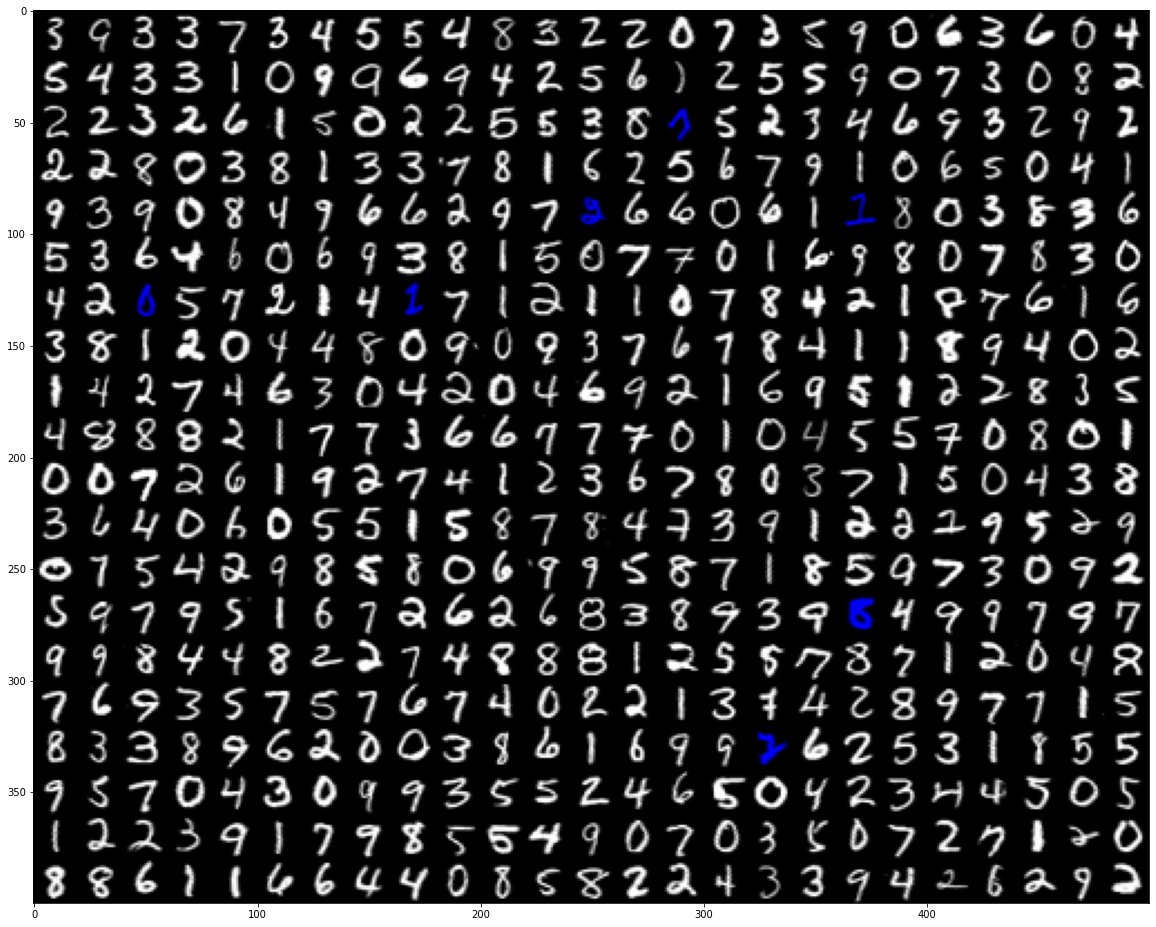

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(vis)